<div align="right">Python 2.7 Jupyter Notebook</div>


This notebook will briefly revisit the Friends and Family dataset for context before demonstrating the generation of summary statistics manually and by using bandicoot. Subsequent sections briefly demonstrate bandicoot's visualization capabilities, how to use bandicoot in combination with network and graph content 

#### Load libraries

In [2]:
import os
import pandas as pd
import bandicoot as bc
import numpy as np
import matplotlib

# 1. Dataset review
Some of the relevant information pertaining to the Friends and Family dataset is repeated here as we will focus on the content of the data during this week's activities.

> An experiment was designed in 2011 to study (a) how people make decisions, with emphasis on the social aspects involved, and (b) how we can empower people to make better decisions using personal and social tools. The data set was collected by Nadav Aharony, Wei Pan, Cory Ip, Inas Khayal, and Alex Pentland. More details about this data set are available [here.] (http://realitycommons.media.mit.edu/friendsdataset.html)

> The subjects are members of a young-family residential living community adjacent to a major research university in North America. All members of the community are couples, and at least one of the members is affiliated with the university. The community is composed of over 400 residents, approximately half of whom have children. A pilot phase of 55 participants was launched in March 2010. In September 2010, phase two of the study included 130 participants - approximately 64 families. Participants were selected out of approximately 200 applicants in a way that would achieve a representative sample of the community and sub-communities (Aharony et al. 2011).

In this module we prepare and analyse the data in a social context using tools and methods introduced in previous modules.
# calculation of average weekly call duration
In order to better understand the process of creating features (referred to as behavioral indicators in bandicoot), you will start by manually creating a feature. Creating features is a tedious process, and using libraries such as bandicoot can significantly reduce the time required to generate features that you would use as input in machine learning algorithms. It is important for you to both understand the process and ensure that the results produced by the libraries are as expected. In other words, you need to make sure that you use the correct function from the library to produce the expected results.

Start by manually computing the average weekly call duration for a specific user based on the interaction log file. This function has been demonstrated in earlier notebooks as it is extremely useful when you need to get a quick view of a dataset without loading it. Should the contents prove useful, you can load it as a dataframe.

In [3]:
# Retrieve the first three rows from the "clean_records" dataset.
!head -n 3 ../data/bandicoot/clean_records/fa10-01-08.csv

interaction,direction,correspondent_id,datetime,call_duration
text,out,fa10-01-08,2010-08-20 17:34:22,
text,in,bd7c809d7d47026e7390ba3c6b253d24efcbe8cf,2010-09-08 11:12:05,


Note that the three lines displayed contains a header row, as well as the first two data rows.

Next, load the dataset using pandas read_csv, and set the index. This example will only focus on calls, and you will create a separate object with an applied filter for calls.

In [4]:
# Specify the user for review.
user_id = 'sp10-01-08'

# Load the dataset and set the index.
interactions = pd.read_csv('../data/bandicoot/clean_records/' + user_id + '.csv')
interactions.set_index(pd.DatetimeIndex(interactions['datetime']), inplace=True)

# Extract the calls. 
calls = interactions[interactions.interaction == 'call'].copy()

# Display the head of the new calls dataframe.
calls.head(3)

,interaction,direction,correspondent_id,datetime,call_duration
2011-02-16 15:28:27,call,out,fa10-01-04,2011-02-16 15:28:27,58.0
2011-02-16 20:05:33,call,out,906fad226144b8d883211608d1f9642f6c584299,2011-02-16 20:05:33,42.0
2011-02-16 20:29:59,call,in,906fad226144b8d883211608d1f9642f6c584299,2011-02-16 20:29:59,365.0


Observe two types of correspondent_id's in the record set. 'fa10-01-04' is in the expected format, and indicates that the party interacted with someone else within the study. The second type is an alphanumeric string which indicates that the user interacted with a party that did not form part of the study. You will require the correspondent_id for the ego network analysis that will be demonstrated in this notebook, and will therefore remove all the records where the correspondent_id is not that of a known member of the study.

In [5]:
calls.dropna(inplace=True)

Performing the calculation is a two-step process:
1. Derive the week of the interaction.
2. Use the pandas "pd.group_by" method demonstrated in Module 2 to add the records to bins.

In [6]:
# Derive the week number for the observation.
calls['week'] = calls.index.map(lambda observation_timestamp: observation_timestamp.week)

# Group by weeks.
week_groups = calls.groupby('week')

# Initialize the intermediate dataframe.
weekly_averages = pd.DataFrame(columns=['week', 'mean_duration', 'std_dev'])
weekly_averages.set_index('week', inplace=True)

# Populate the new dataframe using pandas "mean" and numpy "std" methods.
for week, week_calls in week_groups:
    week_mean = np.mean(week_calls.call_duration)
    week_std  = np.std(week_calls.call_duration)
    weekly_averages.loc[week] = [week_mean, week_std]

# Display the head of the new dataframe.
weekly_averages.head(3)

,mean_duration,std_dev
week,,
7,89.076923,106.805691
8,50.891892,57.033316
9,58.950000,57.964192


In [7]:
# Retrieve the bins (weeks).
list(weekly_averages.index)

[7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

Now that you have the weekly averages and standard deviation of the call duration, you can compute the mean weekly call duration and mean weekly call duration standard deviation.

In [8]:
print ("Average weekly call duration for the user is {:.5f},\nwhile average weekly standard deviation is {:.5f}. "
       .format(weekly_averages.mean_duration.mean(), weekly_averages.std_dev.mean()))

Average weekly call duration for the user is 78.53561,
while average weekly standard deviation is 123.40003. 


While it is possible to use generic data analysis libraries (such as Pandas describe) introduced to you in earlier modules, in the next section you will return to a library briefly introduced to you in Module 2 of this course, bandicoot.

- `weekly_averages.describe()`
- `week_groups.describe()`

##  Using Bandicoot
[Bandicoot](http://bandicoot.mit.edu/docs/index.html) is an open-source python toolbox used to analyze mobile phone metadata. You can perform actions similar to your manual steps with a single command using this library. 

Manual analysis of datasets can be an extremely tedious and resource-intensive process. Although it is outside of the scope of this course, it is important to start considering memory utilization, reproducibility of results, and reuse of intermediate steps when working with large datasets. Toolboxes such as Bandicoot are both optimized for improved performance and specific to mobile phone metadata analysis, meaning that the functions available are specific to the type of data to be analyzed.

Please review the [reference manual](http://bandicoot.mit.edu/docs/reference/index.html) for details on functions, modules, and objects included in Bandicoot. Bandicoot has been preinstalled on your virtual analysis environment. Revisit the [quick guide](http://bandicoot.mit.edu/docs/quickstart.html) should you wish to set up this library in another environment.

The following example starts by loading a dataset that is formatted in Bandicoot’s expected input format in order to redo our calculation. It then goes on to demonstrate additional examples of data manipulation for the same user.

#### Load the data.
As mentioned above, this example will start with using the bandicoot function to load the input file. Note that the import function expects data in a specific format, and it provides additional information that allows you to better understand your dataset.

In [9]:
B = bc.read_csv(user_id, '../data/bandicoot/clean_records/', '../data/bandicoot/antennas.csv')

[x] 3018 records from 2010-07-23 10:02:55 to 2011-05-27 16:23:21
[x] 95 contacts
[ ] No attribute stored
[x] 27 antennas
[ ] No recharges
[x] Has home
[x] Has texts
[x] Has calls
[ ] No network


> **Note**:

> `WARNING:root:100.00% of the records are missing a location.` 

> This message indicates that our dataset does not include any antenna id's. This column was removed from the dataframe in order to preserve user privacy. A [research study](http://www.nature.com/articles/srep01376/) indicated that knowing 4 points (approximate places and times of an individual) was shown to be enough to re-identify the individual in an anonymized dataset in 95% of the cases.


### Compute the weekly average call duration
In Bandicoot you can achieve the same result demonstrated earlier with a single method call named [call_duration](http://bandicoot.mit.edu/docs/reference/generated/bandicoot.individual.call_duration.html).

In [10]:
# Calculate the call_duration summary statistics using Bandicoot.
bc.individual.call_duration(B)

{
    "allweek": {
        "allday": {
            "call": {
                "mean": {
                    "mean": 78.53560794244065, 
                    "std": 22.039203979301334
                }, 
                "std": {
                    "mean": 123.40002832412657, 
                    "std": 64.70661423960068
                }
            }
        }
    }
}

You can see that the above results are in line with the manual calculation (which was rounded to 5 decimals) that you performed earlier.

Bandicoot computes indicators on a weekly basis by default, and returns the average (mean) over all of the weeks available and the standard deviation (std) in a nested dictionary. You can read more about the creation of indicators [here](http://bandicoot.mit.edu/docs/quickstart.html#computing-indicators).

The screenshot below demonstrates the format of the output produced.
![Screenshot of bandicoot weekly patterns for call duration](bandicoot-training-master/mini-mockups-02.png "Screenshot of bandicoot weekly patterns for call duration.")

To change the default behavior and review the daily resolution, you can use "groupby" in Bandicoot as a method call argument. Other grouping parameters include "month", "year" and None.

In [11]:
bc.individual.call_duration(B, groupby='day', interaction='call')

{
    "allweek": {
        "allday": {
            "call": {
                "mean": {
                    "mean": 64.60487040060214, 
                    "std": 38.88886397177002
                }, 
                "std": {
                    "mean": 71.27957421293777, 
                    "std": 75.43950476977011
                }
            }
        }
    }
}

In [12]:

bc.individual.number_of_contacts(B, groupby='month', interaction='call')

{
    "allweek": {
        "allday": {
            "call": {
                "mean": 24.0, 
                "std": 5.244044240850758
            }
        }
    }
}

<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

### 2.2.2 Splitting records
Regardless of grouping scale, it is often useful to stratify the data between weekday and weekend, or day and night. Bandicoot allows you to achieve this with its boolean split arguments, i.e. split_week and split_day. You can read more about Bandicoot’s [number_of_interactions](http://bandicoot.mit.edu/docs/reference/generated/bandicoot.individual.number_of_interactions.html), and execute the code below to view the data on the daily number of interactions stratified with split_week. 




In [12]:
# Use bandicoot to split the records by day.
bc.individual.number_of_interactions(B, groupby='day', split_day=True, interaction='call')

{
    "allweek": {
        "allday": {
            "call": {
                "mean": 6.2560975609756095, 
                "std": 4.119587285774633
            }
        }, 
        "day": {
            "call": {
                "mean": 4.8076923076923075, 
                "std": 3.1462541517456484
            }
        }, 
        "night": {
            "call": {
                "mean": 2.3793103448275863, 
                "std": 1.9811837823756178
            }
        }
    }
}

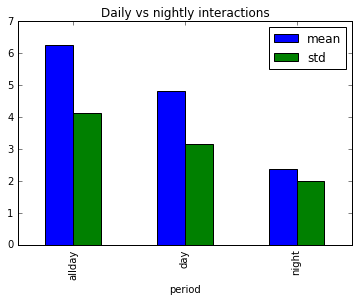

In [13]:
# Plot the results.
%matplotlib inline

interactions_splitByDay = bc.individual.number_of_interactions(B, groupby='day', split_day=True, interaction='call')

interactions_split = []
for period, values in interactions_splitByDay['allweek'].items():
    interactions_split.append([period, values['call']['mean'], values['call']['std']])

interactions_split = pd.DataFrame(interactions_split,columns=['period', 'mean','std'])    
_ = interactions_split.plot(kind='bar' , x='period', title='Daily vs nightly interactions')

Split_day is now introduced as well to view all available strata.

In [15]:
bc.individual.number_of_interactions(B, groupby='day', split_week=True, split_day=True, interaction='call')

{
    "allweek": {
        "allday": {
            "call": {
                "mean": 6.2560975609756095, 
                "std": 4.119587285774633
            }
        }, 
        "day": {
            "call": {
                "mean": 4.8076923076923075, 
                "std": 3.1462541517456484
            }
        }, 
        "night": {
            "call": {
                "mean": 2.3793103448275863, 
                "std": 1.9811837823756178
            }
        }
    }, 
    "weekday": {
        "allday": {
            "call": {
                "mean": 6.5, 
                "std": 3.947573094109004
            }
        }, 
        "day": {
            "call": {
                "mean": 4.964912280701754, 
                "std": 3.1453943622477163
            }
        }, 
        "night": {
            "call": {
                "mean": 2.276595744680851, 
                "std": 1.5804945046189909
            }
        }
    }, 
    "weekend": {
        "allday": {
            

> **Note**:

> The output is as expected. The number of interactions is higher for “day” compared to “night”, as well as for “weekday” compared to “weekend”.

###  Other indicators
Machine learning algorithms utilize features for prediction and clustering tasks. The difficulty arises in manually generating these features, however, using libraries to generate them on your behalf can significantly speed up and standardize the process.



#### Active days (days with at least one interaction)

In [14]:
# Active days.
bc.individual.active_days(B)

{
    "allweek": {
        "allday": {
            "callandtext": {
                "mean": 6.068181818181818, 
                "std": 1.3211174208485112
            }
        }
    }
}

> **Note**: 

> Remember that Bandicoot defaults to grouping by week if the grouping is not explicitly specified.

#### Number of contacts
This number can be interesting, as some research suggests that it is predictable for humans and in the long run it is almost constant for any individual. Please review the articles below for additional information.
- [Your Brain Limits You to Just Five BFFs](https://www.technologyreview.com/s/601369/your-brain-limits-you-to-just-five-bffs/)
- [Limited communication capacity unveils strategies for human interaction](http://www.nature.com/articles/srep01950)

In [15]:
# Number of contacts. 
bc.individual.number_of_contacts(B, split_week=True)

{
    "allweek": {
        "allday": {
            "call": {
                "mean": 10.857142857142858, 
                "std": 3.4404555939406554
            }, 
            "text": {
                "mean": 6.5, 
                "std": 2.2309802166923687
            }
        }
    }, 
    "weekday": {
        "allday": {
            "call": {
                "mean": 9.384615384615385, 
                "std": 2.020603928702107
            }, 
            "text": {
                "mean": 5.604651162790698, 
                "std": 1.7932630370843723
            }
        }
    }, 
    "weekend": {
        "allday": {
            "call": {
                "mean": 4.3076923076923075, 
                "std": 2.16207220347003
            }, 
            "text": {
                "mean": 3.225, 
                "std": 1.8505066873697054
            }
        }
    }
}

> **Note**:

> It looks like there might be a difference between the number of people contacted by phone between the weekend and weekdays.

#### All available features
Bandicoot currently contains 1442 features. You can obtain a quick overview of the features for this dataset using the bandicoot [utils.all](http://bandicoot.mit.edu/docs/reference/generated/bandicoot.utils.all.html#bandicoot.utils.all) function. The three categories of indicators are individual, spatial, and network-related features.

In [16]:
bc.utils.all(B)

{
    "name": "sp10-01-08", 
    "reporting": {
        "antennas_path": "../data/bandicoot/antennas.csv", 
        "attributes_path": None, 
        "recharges_path": None, 
        "version": "0.5.3", 
        "code_signature": "9448acf6f41035dc77ec1442688b811e522ffb4d", 
        "groupby": "week", 
        "split_week": false, 
        "split_day": false, 
        "start_time": "2010-07-23 10:02:55", 
        "end_time": "2011-05-27 16:23:21", 
        "night_start": "19:00:00", 
        "night_end": "07:00:00", 
        "weekend": [
            6, 
            7
        ], 
        "number_of_records": 3018, 
        "number_of_antennas": 27, 
        "number_of_recharges": 0, 
        "bins": 45, 
        "bins_with_data": 44, 
        "bins_without_data": 1, 
        "has_call": true, 
        "has_text": true, 
        "has_home": true, 
        "has_recharges": false, 
        "has_attributes": false, 
        "has_network": false, 
        "percent_records_missing_location": 1

> **Note**:

> Great, just "The reporting variables allows you to better understand the nature and origin of the data as well as which computations have been performed (which version of the code etc). In earlier modules we started to perform some manual checks on data quality. Experience will teach you that this step always takes longer than anticipated and requires significant effort to determine the relevant questions and to execute them. Using a standardized library such as bandicoot saves both time in analyzing datasets and spotting issues, and makes the actions repeatable or comparable with other datasets or analyses.

#  Visualization with Bandicoot

The visualization demonstrated in Module 2 will be repeated now that you have more background information on the toolbox and its capabilities. As Yves-Alexandre de Montjoye mentioned in the video content, visualization is a powerful tool, not just for communicating your final results, but also in terms of checking the validity of your data, to identify errors and outliers, as well as in identifying useful patterns visually that hides in aggregated datasets.

In [17]:
# Import the relevant libraries.
import os
from IPython.display import IFrame

# Set the path to store the visualization.
viz_path = os.path.dirname(os.path.realpath(__name__)) + '/viz'

# Create the visualization.
bc.visualization.export(B, viz_path)

# Display the visualization in a frame within this notebook.
IFrame("./viz/index.html", "100%", 700)

Successfully exported the visualization to /home/ubuntu/projects/module_5/viz


#  Graphs and matrices

This section contains network indicators, a gender assortativity example, and a brief demonstration on how to use Bandicoot to generate input for visualizations using NetworkX. You started the course with Professor Pentland describing general patterns in behavior that are observed between individuals. Understanding the individual as a part of a network is an extremely useful way to evaluate how they resemble or do not resemble their friends, as well as the role they play in their network or community.

In our current dataset, “Friends and Family”, the majority of interactions take place outside of the population in the study, therefore performing the calculations on this dataset does not make sense. This is because the data is not representative of the full network of contacts. In a commercial application you would most likely encounter a similar situation as there are multiple carriers, each with only a portion of the total market share. The figures differ per country but typically fall in the range of 10-30% market share for the main (dominant) carriers.

 

A useful feature of Bandicoot, is that it is very quick to analyze a user's ego network, or individual focus node, if the input data is properly formatted. You start by loading the "ego" in question to a Bandicoot object. You need to set the network parameter to "True". Bandicoot will attempt to extract all "ego" interaction data, as well as do the network analysis for the data contained in the specified network folder.

## 4.1 Load the data

In [18]:
# Specify the network folder containing all the data.
network_folder  = '../data/bandicoot/network_records/'

# Create Bandicoot object.
BN = bc.read_csv(user_id, network_folder, attributes_path='../data/bandicoot/attributes',network=True)

         call_duration: 356 record(s) with incomplete values
         No antennas file was given and records are using antennas for position.


[x] 1420 records from 2010-07-23 10:02:55 to 2011-05-27 14:44:21
[x] 7 contacts
[x] 2 attributes
[ ] No antenna stored
[ ] No recharges
[x] Has home
[x] Has texts
[ ] No calls
[x] Has network


The bandicoot function loads the data, provides summary information and removes the records that are not of interest in the analysis. Performing the data cleansing steps are typically time consuming and prone to error or inconsistencies. The graph data is stored as an adjacency matrix.



## 4.2 Network indicators

In [19]:
# Index of the adjacency matrix - user_ids participating in the network.
node_labels = bc.network.matrix_index(BN)
node_labels

['sp10-01-08',
 'fa10-01-14',
 'fa10-01-20',
 'sp10-01-07',
 'sp10-01-38',
 'sp10-01-39',
 'sp10-01-41',
 'sp10-01-49']

There are several types of adjacency matrices available in Bandicoot, namely:

* `bc.network.matrix_directed_weighted(network_user)`
* `bc.network.matrix_directed_unweighted(network_user)`
* `bc.network.matrix_undirected_weighted(network_user)`
* `bc.network.matrix_undirected_unweighted(network_user)`

You can review [Bandicoot network documentation](http://bandicoot.mit.edu/docs/reference/bandicoot.network.html) for additional information.

In [20]:
# Directed unweighted matrix.
directed_unweighted = bc.network.matrix_directed_unweighted(BN)
directed_unweighted

[[0, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 0, 0, 0, 1, 1, 1],
 [1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 1, 0, 1, 0],
 [1, 0, 0, 1, 0, 1, 1, 0],
 [1, 1, 0, 1, 1, 0, 1, 1],
 [1, 1, 0, 0, 1, 1, 0, 1],
 [1, 1, 0, 1, 0, 1, 1, 0]]

In [21]:
# Undirected weighted matrix.
undirected_weighted = bc.network.matrix_undirected_weighted(BN)
undirected_weighted

[[0, 6, 7, 397, 6, 130, 8, 544],
 [6, 0, 0, 0, 0, 3, 10, 14],
 [7, 0, 0, 0, 0, 0, 0, 0],
 [397, 0, 0, 0, 56, 0, 0, 0],
 [6, 0, 0, 56, 0, 1052, 2, 0],
 [130, 3, 0, 0, 1052, 0, 27, 216],
 [8, 10, 0, 0, 2, 27, 0, 39],
 [544, 14, 0, 0, 0, 216, 39, 0]]

##Gender assortativity
This indicator computes the assortativity of nominal attributes. More specifically, it measures the similarity of the current user with his or her correspondents for all bandicoot indicators. For each one, it calculates the variance of the current user’s value with the values for all their correspondents. This indicator measures the homophily of the current user with their correspondents, for each attribute. It returns a value between 0 (no assortativity) and 1 (all the contacts share the same value), which indicates the percentage of contacts sharing the same value.

Let's demonstrate this by reviewing the gender assortativity.

In [24]:
bc.network.assortativity_attributes(BN)['gender']

0.7142857142857143


Yes, Higher values shows stronger correlation between the nodes.there is a high incidence of homophily.

##  Ego network visualization

 use the ego network adjacency matrices for further analyses in NetworkX.

In [22]:
# Load the relevant libraries and set plotting options.
import networkx as nx
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,11)

Create directed unweighted and undirected weighted graphs to visualize the network to better understand the user behaviour as per the examples in section 1.2 of module 4 notebook 2.

In [23]:
# Create the graph objects.
G_directed_unweighted = nx.from_numpy_matrix(np.array(directed_unweighted))
G_undirected_weighted = nx.from_numpy_matrix(np.array(undirected_weighted))
node_labels = dict(enumerate(node_labels))

#### Plot the directed unweighted graph.
This can typically be utilized to better understand the flow or spread of information.

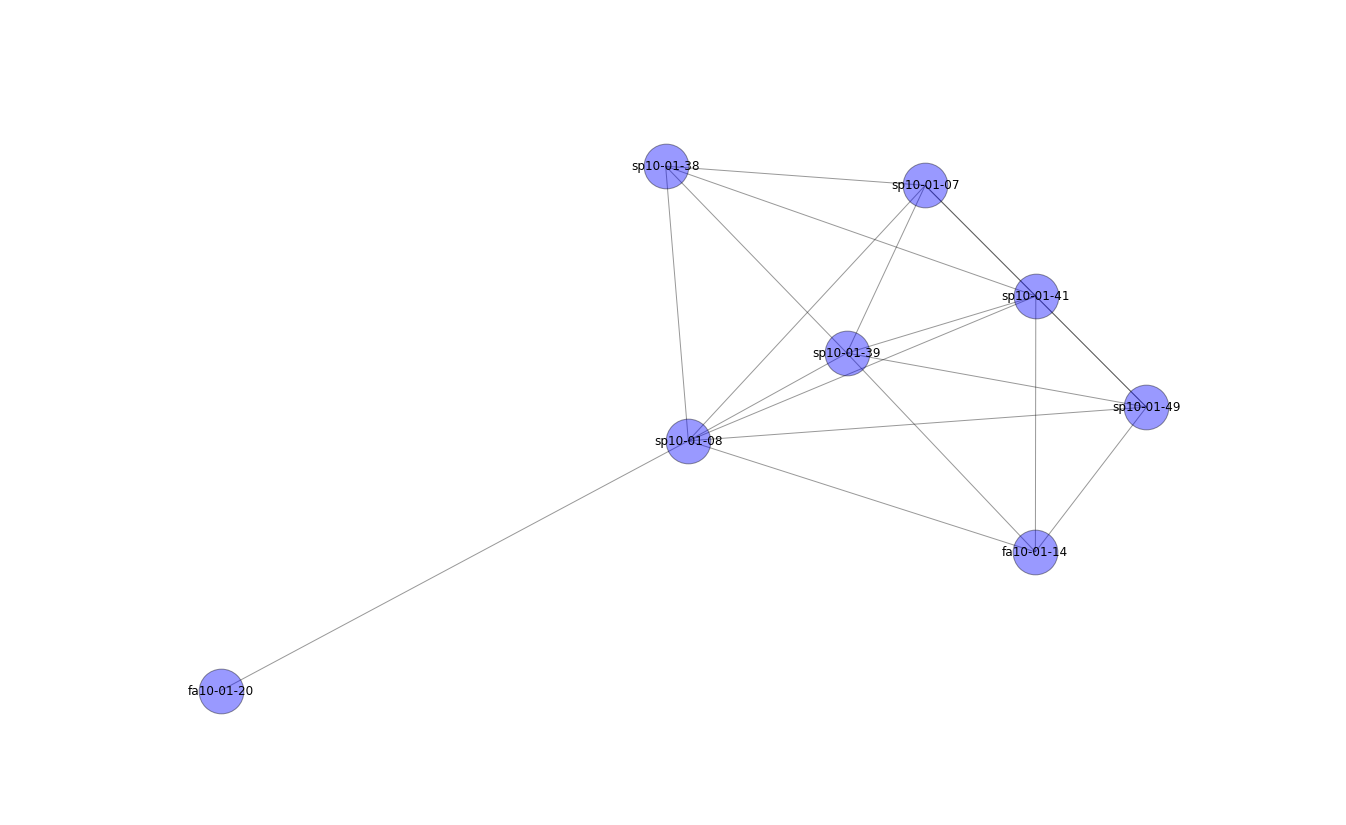

In [24]:
# Plot the graph.
layout = nx.spring_layout(G_directed_unweighted)
nx.draw(G_directed_unweighted, layout, node_color='blue', alpha=0.4, node_size=2000)
_ = nx.draw_networkx_labels(G_directed_unweighted, layout, node_labels)

#### Plot the undirected weighted graph.
This can typically be utilized to better understand the importance of the various individuals and their interactions in the network.

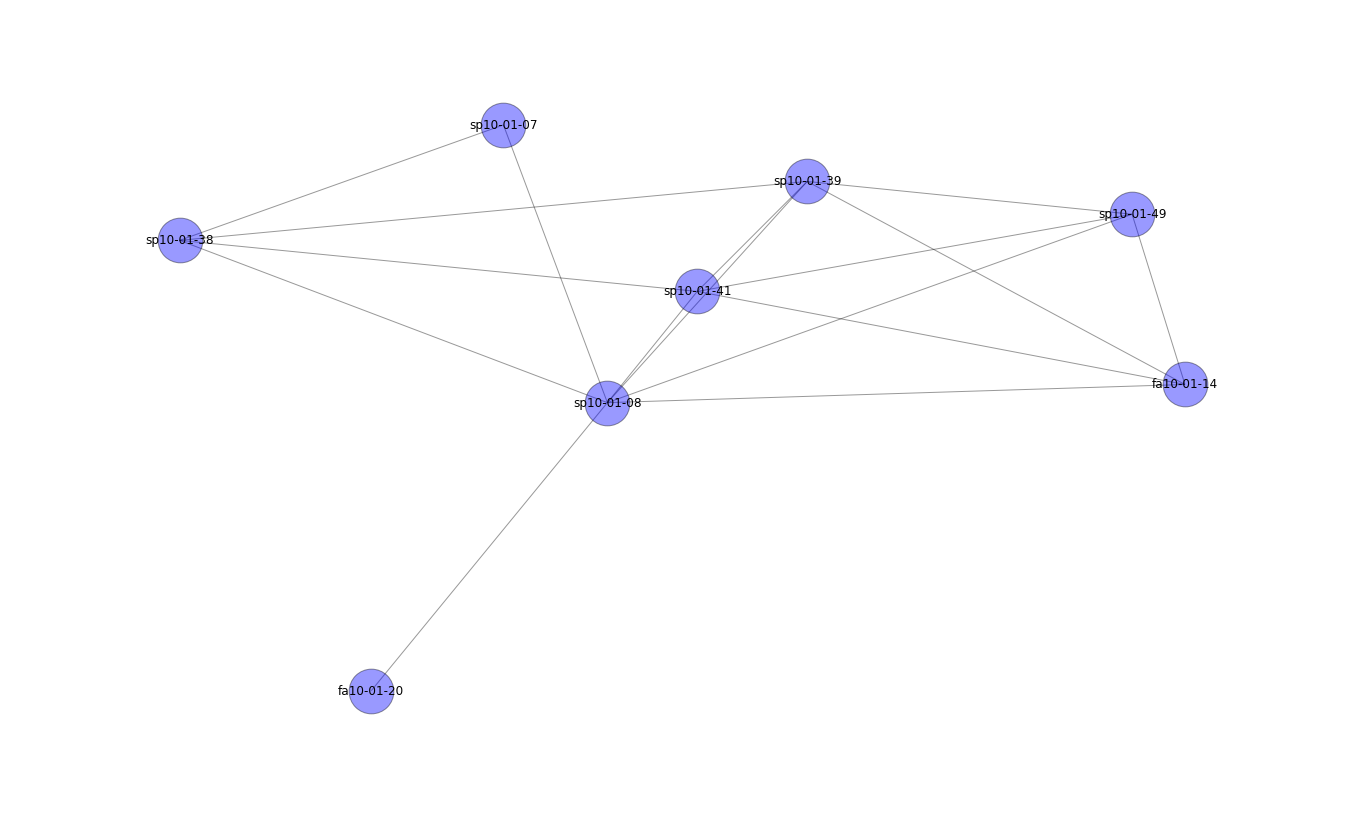

In [25]:
# Plot the graph.
layout = nx.spring_layout(G_directed_unweighted)
nx.draw(G_undirected_weighted, layout, node_color='blue', alpha=0.4, node_size=2000)
_ = nx.draw_networkx_labels(G_undirected_weighted, layout, node_labels)

# Data error handling
This section demonstrates some of Bandicoot’s error handling and reporting strategies for some of the "faulty" users.
Some circumstances may require working with CDR records and collected mobile phone metadata that have been corrupted. The reasons for this can be numerous, but typically include: wrong formats, faulty files, empty periods of time, missing users, etc. Bandicoot will not attempt to correct errors as this might lead to incorrect analyses. Correctness is key in data science and bandicoot will:

1. Warn you when you attempt to import corrupted data;
2. Remove faulty records; and
3. Report on more than 30 variables (such as the number of contacts, types of records, records containing location), warning you of potential issues when exporting indicators.

## Bandicoot csv import
Importing csv files with bandicoot will produce warnings about:

1. No files containing data being found in the specified path.
2. The percentage of records missing location information.
3. The number of antennas missing geotags (provided the antenna file has been loaded).
4. The fraction of duplicated records.
5. The fraction of calls with an overlap bigger than 5 minutes.


In [26]:
# Set the path and user for demonstration purposes.
antenna_file             = '../data/bandicoot/antennas.csv'
attributes_path          = '../data/bandicoot/attributes/'
records_with_errors_path = '../data/bandicoot/records/'
error_user_id            = 'fa10-01-04'

##  Error example

In [27]:
errors = bc.read_csv(error_user_id, records_with_errors_path )

[x] 2408 records from 2010-09-20 13:48:57 to 2011-05-23 22:25:08
[x] 54 contacts
[ ] No attribute stored
[ ] No antenna stored
[ ] No recharges
[x] Has home
[x] Has texts
[x] Has calls
[ ] No network


         call_duration: 1458 record(s) with incomplete values
         No antennas file was given and records are using antennas for position.


You can review the errors below to quickly get a view of your dataset. This example includes warnings that are in addition to the missing location and antenna warnings explained earlier. The new warnings include:

1. Missing values of call duration.
2. Duplicate records.
3. Overlapping records.

### Rows with missing values
These rows are prudently excluded and their details can be examined using `errors.ignored_records`.

In [28]:
errors.ignored_records

{'all': 1458,
 'call_duration': 1458,
 'correspondent_id': 0,
 'datetime': 0,
 'direction': 0,
 'interaction': 0,
 'location': 0}

###  Duplicated records
 These records are retained by default, but you can change this behavior by adding the parameter “drop_duplicates=True” when loading files.


In [32]:
errors = bc.read_csv(error_user_id, records_with_errors_path, drop_duplicates=True)

[x] 2008 records from 2010-09-20 13:48:57 to 2011-05-23 22:25:08
[x] 54 contacts
[ ] No attribute stored
[ ] No antenna stored
[ ] No recharges
[x] Has home
[x] Has texts
[x] Has calls
[ ] No network


         call_duration: 1458 record(s) with incomplete values
         No antennas file was given and records are using antennas for position.
Warning! 400 duplicated record(s) were removed.


#  Loading the full dataset
In this section, you will load the full “Friends and Family” reality commons dataset and compute all the metrics

In [29]:
# View the files in the directory using the operating system list function.
!ls ../data/bandicoot/clean_records/ 

fa10-01-01.csv	fa10-01-27.csv	fa10-01-53.csv	fa10-01-79.csv	sp10-01-29.csv
fa10-01-02.csv	fa10-01-28.csv	fa10-01-54.csv	fa10-01-80.csv	sp10-01-30.csv
fa10-01-03.csv	fa10-01-29.csv	fa10-01-55.csv	fa10-01-81.csv	sp10-01-31.csv
fa10-01-04.csv	fa10-01-30.csv	fa10-01-56.csv	fa10-01-82.csv	sp10-01-32.csv
fa10-01-05.csv	fa10-01-31.csv	fa10-01-57.csv	fa10-01-83.csv	sp10-01-33.csv
fa10-01-06.csv	fa10-01-32.csv	fa10-01-58.csv	fa10-01-85.csv	sp10-01-34.csv
fa10-01-07.csv	fa10-01-33.csv	fa10-01-59.csv	fa10-01-86.csv	sp10-01-35.csv
fa10-01-08.csv	fa10-01-34.csv	fa10-01-60.csv	sp10-01-01.csv	sp10-01-36.csv
fa10-01-09.csv	fa10-01-35.csv	fa10-01-61.csv	sp10-01-02.csv	sp10-01-37.csv
fa10-01-10.csv	fa10-01-36.csv	fa10-01-62.csv	sp10-01-05.csv	sp10-01-38.csv
fa10-01-11.csv	fa10-01-37.csv	fa10-01-63.csv	sp10-01-06.csv	sp10-01-39.csv
fa10-01-12.csv	fa10-01-38.csv	fa10-01-64.csv	sp10-01-07.csv	sp10-01-40.csv
fa10-01-13.csv	fa10-01-39.csv	fa10-01-65.csv	sp10-01-08.csv	sp10-01-41.csv
fa10-01-14.csv	fa10-01-40

##  Load the files and create a metric
You can review the bandicoot [utils.all](http://bandicoot.mit.edu/docs/reference/generated/bandicoot.utils.all.html#bandicoot.utils.all) page for more detail.

In [30]:
# Load libraries and set path options.
import glob, os
records_path    = '../data/bandicoot/clean_records/'

# Create an empty list and then cycle through each of the available files in the directory to add features.
features = []
for f in glob.glob(records_path + '*.csv'):
    user_id = os.path.basename(f)[:-4]

    try:
        B = bc.read_csv(user_id, records_path, attributes_path=attributes_path, describe=False, warnings=False)
        metrics_dict = bc.utils.all(B, summary='extended', split_day=True, split_week=True)
    except Exception as e:
        metrics_dict = {'name': user_id, 'error': str(e)}

    features.append(metrics_dict)

## Save the interactions in a file for future use


In [31]:
bc.io.to_csv(features, 'all_features.csv')

Successfully exported 129 object(s) to all_features.csv


Before moving on, take a quick look at the results of the pipeline.

#### Review the data for the first user.
Keep in mind that in manual approaches, you would likely have to create each of these features by hand. The process entails thinking about features and reviewing available literature to identify applicable features. These features are used in machine learning techniques (including feature selection) for various use cases.



In [32]:
features[:1]

[{
    "name": "sp10-01-45", 
    "reporting": {
        "antennas_path": None, 
        "attributes_path": "../data/bandicoot/attributes/", 
        "recharges_path": "../data/bandicoot/attributes/", 
        "version": "0.5.3", 
        "code_signature": "9448acf6f41035dc77ec1442688b811e522ffb4d", 
        "groupby": "week", 
        "split_week": true, 
        "split_day": true, 
        "start_time": "2010-07-26 23:33:53", 
        "end_time": "2011-05-27 10:19:24", 
        "night_start": "19:00:00", 
        "night_end": "07:00:00", 
        "weekend": [
            6, 
            7
        ], 
        "number_of_records": 1532, 
        "number_of_antennas": 0, 
        "number_of_recharges": 0, 
        "bins": 44, 
        "bins_with_data": 44, 
        "bins_without_data": 0, 
        "has_call": true, 
        "has_text": true, 
        "has_home": true, 
        "has_recharges": false, 
        "has_attributes": true, 
        "has_network": false, 
        "percent_recor

#### Review the number of users.

In [33]:
# Display the length or number of features.
len(features)

129